In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from machining_positions.load import SVGBezierLoader
from machining_positions.compute import (
    envelope_from_svg_points,
    machining_positions_and_distances_from_envelope,
    dataframe_from_machining_positions_and_distances,
)
from scipy.spatial import distance
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
import pandas as pd
import numpy as np

In [4]:
paths = SVGBezierLoader("Champ Dragon Ladies - V2.svg").load()

In [44]:
envelope_array_list = []
machining_positions_list = []
for path in tqdm(paths):
    envelope_array = envelope_from_svg_points(path, 100)
    envelope_array_list.append(envelope_array)
    (
        machining_positions,
        machining_distances,
    ) = machining_positions_and_distances_from_envelope(envelope_array, resolution=1)
    machining_positions_list.append(machining_positions)
    break

  0%|          | 0/44 [00:00<?, ?it/s]


In [45]:
envelope_array_df = (
    pd.concat(
        dict(
            zip(range(len(envelope_array_list)), map(pd.DataFrame, envelope_array_list))
        )
    )
    .rename(columns={0: "x", 1: "y"})
    .reset_index(level=0, names=("shape"))
)
machining_positions_df = (
    pd.concat(
        dict(
            zip(range(len(machining_positions_list)), map(pd.DataFrame, machining_positions_list))
        )
    )
    .rename(columns={0: "x", 1: "y"})
    .reset_index(level=0, names=("shape"))
)

In [46]:
def closest_point(point, points):
    distances = distance.cdist([point], points)
    index_closest = distances.argmin()
    distance_closest = distances[0, index_closest]
    return points[index_closest], index_closest, distance_closest

In [47]:
start_index = machining_positions.argmin(axis=0)[0]
# Find the closest point to the start point that is not the start point
# machining_positions is a numpy array, so we have to index it properly to
# remove only start_index from the search
search_positions = machining_positions[np.arange(len(machining_positions)) != start_index]
ordered_points_all = []
ordered_points_subset = []
current_distances = []
while len(search_positions) > 0:
    next_point, next_index, next_distance = closest_point(first_point, search_positions)
    search_positions = search_positions[np.arange(len(search_positions)) != next_index]
    current_distances.append(next_distance)
    if next_distance > 5*sum(current_distances)/len(current_distances):
        ordered_points_all.append(ordered_points_subset)
        ordered_points_subset = []
        current_distances = []
    ordered_points_subset.append(next_point)
    first_point = next_point
ordered_points_all.append(ordered_points_subset)

In [59]:
# Concatenate all the ordered points into a single array with a point NaN separator between each subset
ordered_points_array = np.concatenate(
    [np.concatenate([np.array(ordered_points_subset), np.array([[np.nan, np.nan]])]) for ordered_points_subset in ordered_points_all]
)
ordered_points_array

array([[577.55606617, 602.89727845],
       [577.54520521, 603.6074461 ],
       [576.86154591, 604.86690161],
       [576.7563031 , 605.24966959],
       [576.11609629, 606.51823359],
       [575.99274673, 606.87663332],
       [575.7705416 , 607.32887801],
       [575.45065155, 607.37293482],
       [575.24284314, 607.37773034],
       [574.4576076 , 607.48608041],
       [574.24883925, 607.49069315],
       [573.46454275, 607.59912365],
       [573.25470992, 607.60354844],
       [572.47153572, 607.71204045],
       [572.26051203, 607.71627197],
       [571.47856968, 607.8248171 ],
       [571.26625971, 607.82884873],
       [570.48543389, 607.93747023],
       [570.27201673, 607.94128982],
       [569.4922721 , 608.04999994],
       [569.27768101, 608.05359965],
       [568.49908281, 608.16239703],
       [568.28326799, 608.16576817],
       [567.50586462, 608.27465415],
       [567.28880216, 608.27778712],
       [566.51283886, 608.38673573],
       [566.29432135, 608.38962277],
 

(496.0265, 587.4035000000001, 601.874, 615.866)

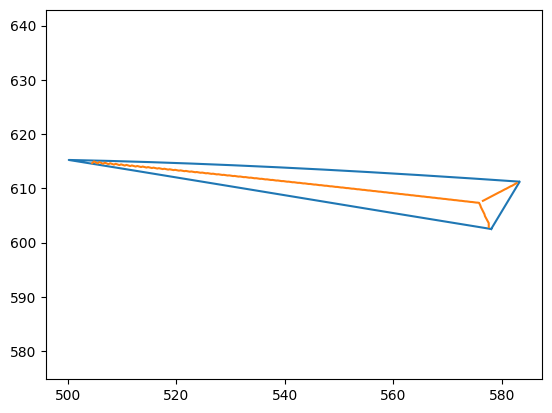

In [60]:
plt.plot(*envelope_array.T)
# plt.plot(*machining_positions.T)
plt.plot(*ordered_points_array.T)
# for points in ordered_points_all:
#     plt.scatter(*np.array(points).T)
plt.axis("equal")

In [ ]:
# Create the line plot
fig = px.line(envelope_array_df, x="x", y="y", color="shape")

for shape in machining_positions_df["shape"].unique():
    mask_shape = machining_positions_df["shape"] == shape
    # n_sample = int(0.2 * mask_shape.sum())
    # machining_positions_shape = machining_positions_df[mask_shape].sample(n_sample)
    machining_positions_shape = machining_positions_df[mask_shape]
    fig.add_scatter(
        x=machining_positions_shape["x"],
        y=machining_positions_shape["y"],
        mode="markers",
    )
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)

In [41]:
px.line(machining_positions_df[machining_positions_df["shape"]==0], x="x", y="y")